## Before you start

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `GPU`, and then click `Save`.

In [1]:
!nvidia-smi

Wed Aug  9 23:09:10 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   50C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import torch
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Wed_Sep_21_10:33:58_PDT_2022
Cuda compilation tools, release 11.8, V11.8.89
Build cuda_11.8.r11.8/compiler.31833905_0
torch:  2.0 ; cuda:  cu118


In [3]:
import os
HOME = os.getcwd()
print(HOME)

/content


## Install YOLOv8

In [4]:
!pip install ultralytics

from IPython import display
display.clear_output()

import ultralytics
ultralytics.checks()

Ultralytics YOLOv8.0.151 🚀 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 24.4/78.2 GB disk)


## Install Supervision

In [5]:
!pip install supervision==0.2.0

from IPython import display
display.clear_output()
# reusable computer vision tool i use it for handle yolo and make detections
import supervision as sv
print("supervision", sv.__version__)

supervision 0.2.0


## Download data

In [7]:
GYM_VIDEO_PATH = f"{HOME}/AI Intern Video Tech Task.mp4"

## Simple YOLOv8 Shopping Mall Example

In [8]:
from ultralytics import YOLO

model = YOLO('yolov8s.pt')

100%|██████████| 21.5M/21.5M [00:00<00:00, 41.0MB/s]


In [9]:
sv.VideoInfo.from_video_path(GYM_VIDEO_PATH)

VideoInfo(width=960, height=1080, fps=11, total_frames=1988)

In [24]:
import numpy as np
import supervision as sv
import cv2
# initiate polygon zone
polygon = np.array([
    [300, 0],
    [960, 0],
    [960, 1080],
    [300, 1080],
    [0,1080],
    [0,400],
    [300,370]
])
video_info = sv.VideoInfo.from_video_path(GYM_VIDEO_PATH)
zone = sv.PolygonZone(polygon=polygon, frame_resolution_wh=video_info.resolution_wh)

# initiate annotators
box_annotator = sv.BoxAnnotator(thickness=4, text_thickness=4, text_scale=2)
zone_annotator = sv.PolygonZoneAnnotator(zone=zone, color=sv.Color.white(), thickness=4)

def process_frame(frame: np.ndarray, _) -> np.ndarray:
    # detect
    results = model(frame, imgsz=1280)[0]
    detections = sv.Detections.from_yolov8(results)
    detections = detections[detections.class_id == 0]
    zone.trigger(detections=detections)

    # annotate
    box_annotator = sv.BoxAnnotator(thickness=4, text_thickness=4, text_scale=2)
    labels = [f"{model.names[class_id]} {confidence:0.2f}" for _, confidence, class_id, _ in detections]
    #frame = box_annotator.annotate(scene=frame, detections=detections, labels=labels)
    frame = zone_annotator.annotate(scene=frame)

    return frame

sv.process_video(source_path=GYM_VIDEO_PATH, target_path=f"{HOME}/test-result.mp4", callback=process_frame)

from IPython import display
display.clear_output()


0: 1280x1152 1 person, 45.7ms
Speed: 11.7ms preprocess, 45.7ms inference, 1.9ms postprocess per image at shape (1, 3, 1280, 1152)


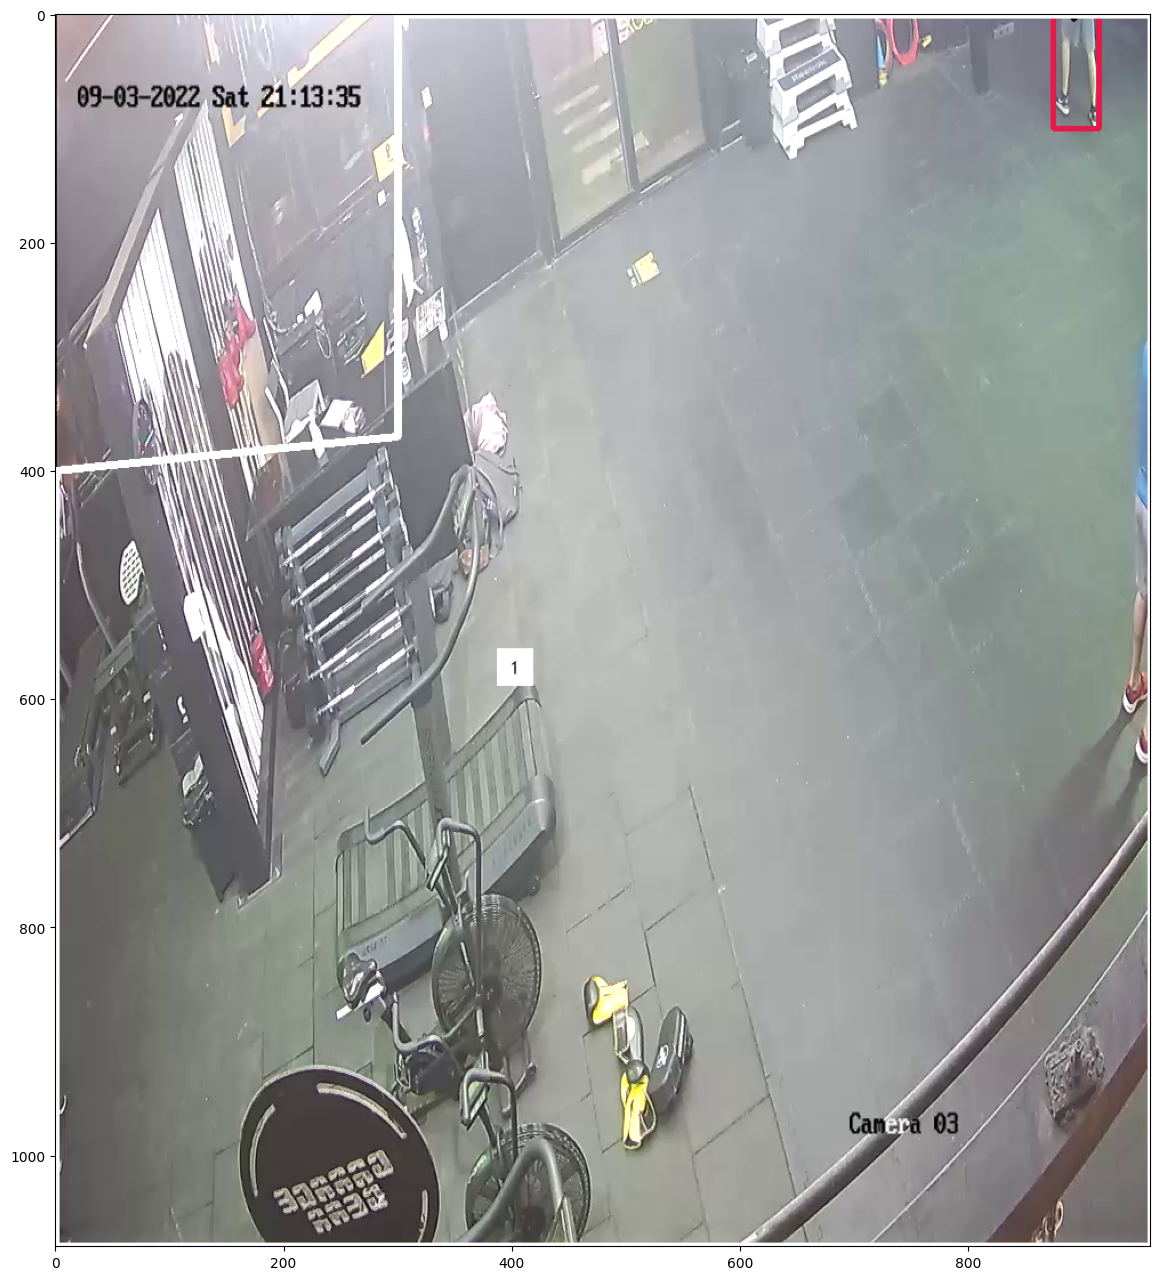

In [23]:
import supervision as sv
import numpy as np

polygon = np.array([
    [300, 0],
    [960, 0],
    [960, 1080],
    [300, 1080],
    [0,1080],
    [0,400],
    [300,370]
])
video_info = sv.VideoInfo.from_video_path(GYM_VIDEO_PATH)
zone = sv.PolygonZone(polygon=polygon, frame_resolution_wh=video_info.resolution_wh)

# initiate annotators
box_annotator = sv.BoxAnnotator(thickness=4, text_thickness=4, text_scale=2)
zone_annotator = sv.PolygonZoneAnnotator(zone=zone, color=sv.Color.white(), thickness=6)

# extract video frame
generator = sv.get_video_frames_generator(GYM_VIDEO_PATH)
iterator = iter(generator)
frame = next(iterator)

# detect
results = model(frame, imgsz=1280)[0]
detections = sv.Detections.from_yolov8(results)
detections = detections[detections.class_id == 0]
zone.trigger(detections=detections)

# annotate
box_annotator = sv.BoxAnnotator(thickness=4, text_thickness=4, text_scale=2)
labels = [f"{model.names[class_id]} {confidence:0.2f}" for _, confidence, class_id, _ in detections]
frame = box_annotator.annotate(scene=frame, detections=detections, labels=labels)
frame = zone_annotator.annotate(scene=frame)

%matplotlib inline
sv.show_frame_in_notebook(frame, (16, 16))